In [1]:
library(tidyverse)

library(grid)
library(gridExtra)

source("/home/yuliya/repos/other/removeBatch/evaluation_utils/plots_eda.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Warning message:
“package ‘ggsci’ was built under R version 4.3.3”


# Load data

In [19]:
data_path <- "/home/yuliya/repos/other/removeBatch/evaluation_data/microbiome/"


central_corrected <- read.csv(paste0(data_path, "after/normalized_logmin_counts_5centers_corrected_CENTRAL.tsv"), sep = "\t", header = TRUE, row.names = 1, check.names = F)
rownames(central_corrected) <- central_corrected$MSP
central_corrected <- central_corrected[, -1]

central_uncorrected <- read.csv(paste0(data_path, "before/normalized_counts_5C.tsv"), sep = "\t", header = TRUE, row.names = 1, check.names = F)
rownames(central_uncorrected) <- central_uncorrected$MSP
central_uncorrected <- central_uncorrected[, -1]

metadata <- read.csv(paste0(data_path, "before/metadata_5C.tsv"), sep = "\t", header = TRUE, row.names = 1)
rownames(metadata) <- metadata$sample

# log10 + 0.5 minimal non-zero value for log transformation
central_uncorrected <- log10(central_uncorrected + 0.5*min(central_uncorrected[central_uncorrected > 0]))

# remove X from row names
rownames(metadata) <- gsub("X", "", rownames(metadata))
metadata$file <- rownames(metadata)
# order the columns in intensity dataframes
central_corrected <- central_corrected[, rownames(metadata)]
central_uncorrected <- central_uncorrected[, rownames(metadata)]

cat("Loaded data")
cat("Central corrected:", nrow(central_corrected), "rows\n")
cat("Central uncorrected:", nrow(central_uncorrected), "rows\n")
cat("Sample metadata:", nrow(metadata), "rows\n\n")



Loaded dataCentral corrected: 845 rows
Central uncorrected: 845 rows
Sample metadata: 685 rows



# Checks

## Diagnostic plots

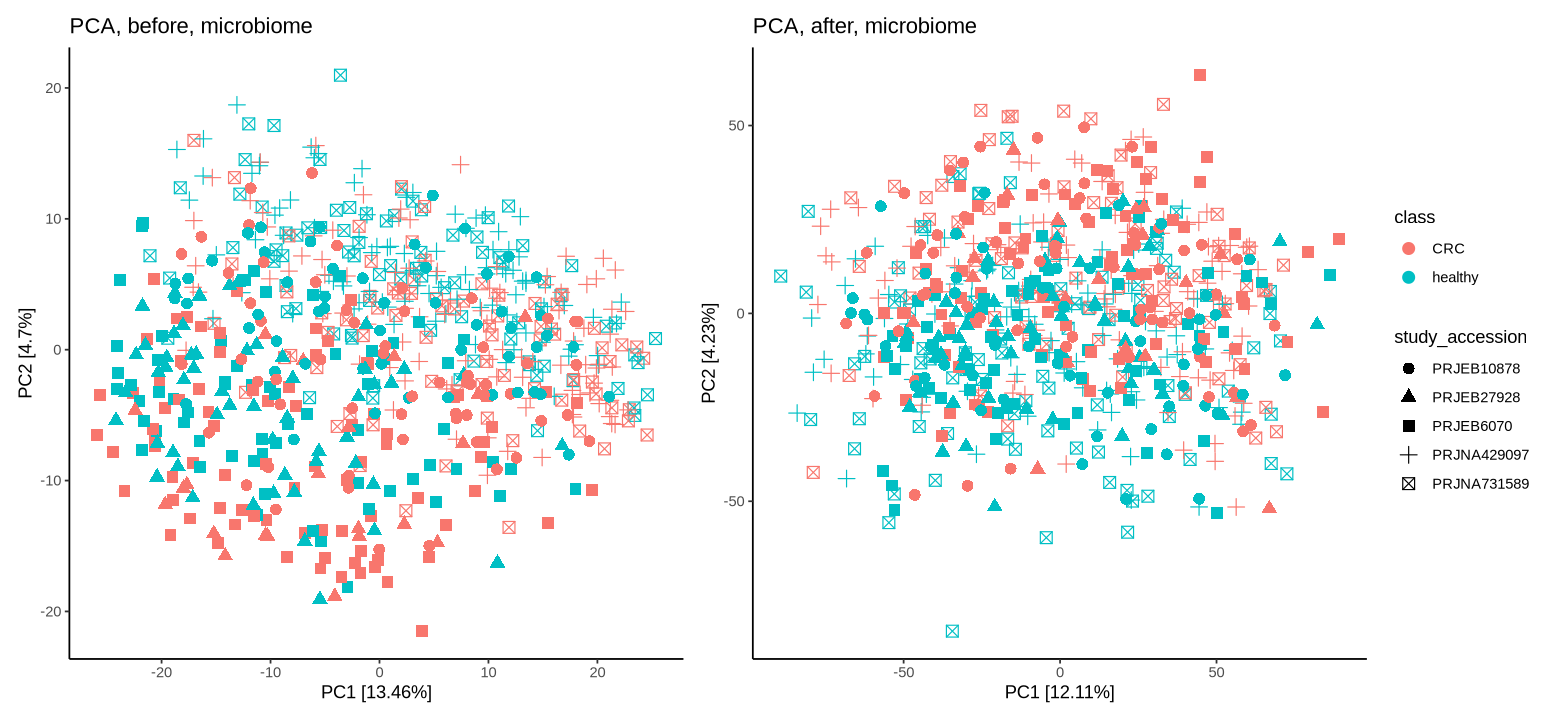

In [20]:
pca_plot_uncorrected <- pca_plot(central_uncorrected, metadata, 
    title = paste("PCA, before, microbiome"),
    quantitative_col_name = "sample", col_col = "class", shape_col="study_accession", show_legend=F)
pca_plot_corrected <- pca_plot(central_corrected, metadata, 
    title = paste("PCA, after, microbiome"),
    quantitative_col_name = "sample", col_col = "class", shape_col="study_accession", show_legend=T)

layout <- (pca_plot_uncorrected + pca_plot_corrected)

options(repr.plot.width=13, repr.plot.height=6)
layout

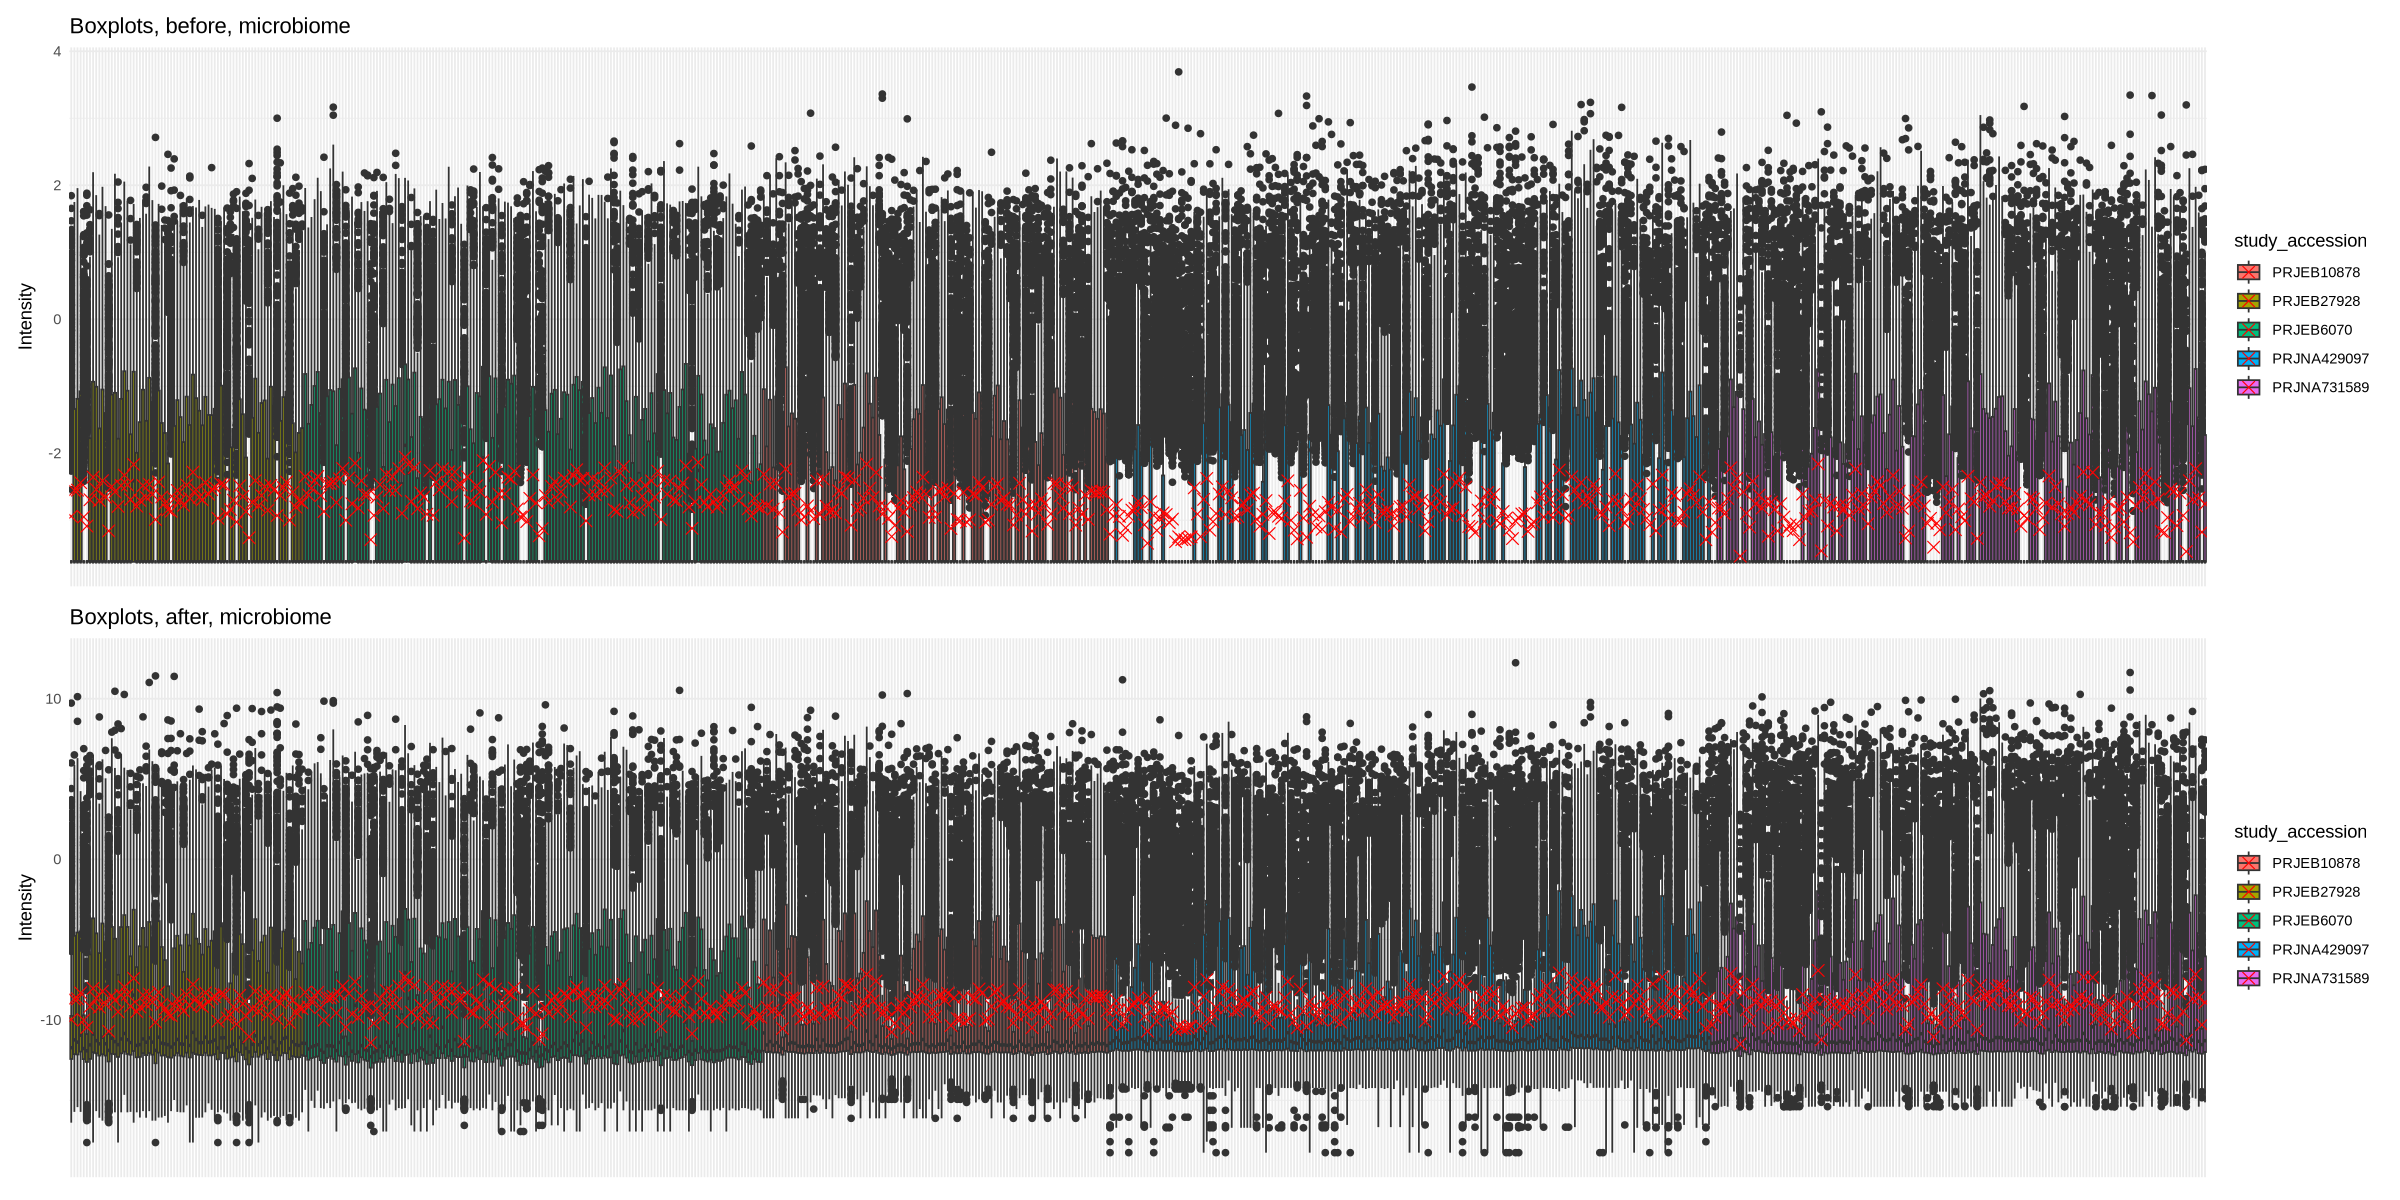

In [22]:
boxplots_uncorrected <- boxplot_plot(central_uncorrected, metadata,
    title = paste("Boxplots, before, microbiome"),
    quantitativeColumnName = "sample",
    color_col = "study_accession", remove_xnames = T)
boxplots_corrected <- boxplot_plot(central_corrected, metadata, 
    title = paste("Boxplots, after, microbiome"),
    quantitativeColumnName = "sample",
    color_col = "study_accession", remove_xnames = T)

layout <- boxplots_uncorrected  /
            boxplots_corrected

options(repr.plot.width=20, repr.plot.height=10)
layout

No id variables; using all as measure variables

No id variables; using all as measure variables



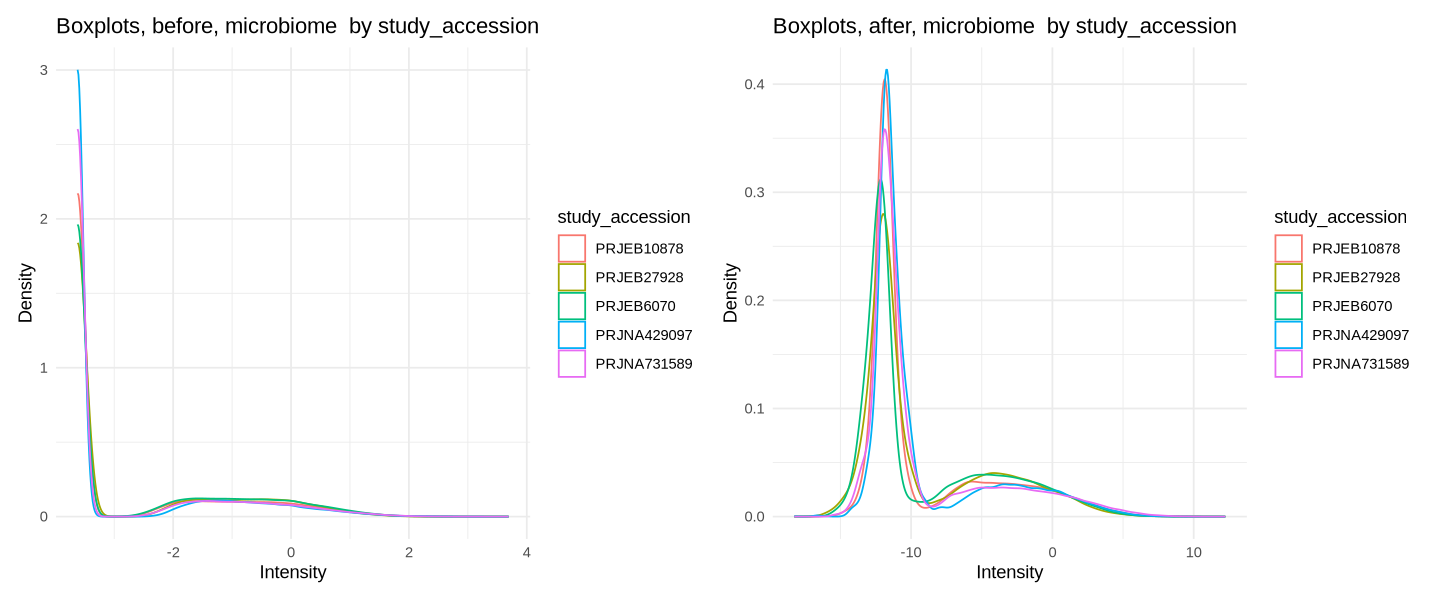

In [23]:
density_plots_uncorrected <- plotIntensityDensity(central_uncorrected, metadata, 
    title = paste("Boxplots, before, microbiome"),
    quantitativeColumnName = "sample",
    colorColumnName = "study_accession")
density_plots_corrected <- plotIntensityDensity(central_corrected, metadata, 
    title = paste("Boxplots, after, microbiome"),
    quantitativeColumnName = "sample",
    colorColumnName = "study_accession")

layout <- (density_plots_uncorrected + density_plots_corrected) 

options(repr.plot.width=12, repr.plot.height=5)
layout


##  Linear model per variable

Following batch effect correction, the percentage of variance explained by the condition should be greater than the batch.

In [24]:
library(variancePartition)

Loading required package: limma

Loading required package: BiocParallel


Attaching package: ‘variancePartition’


The following object is masked from ‘package:limma’:

    topTable




In [25]:
lmpv_plot <- function(data, metadata, title){
    form <- ~ class + study_accession

    varPart <- fitExtractVarPartModel(na.omit(data), form, metadata)
    variance_col <- as.matrix(varPart[,1:2])

    df_long <- reshape2::melt(variance_col)

    # Plotting the boxplots using ggplot2
    ggplot(df_long, aes(x = Var2, y = value, fill=Var2)) +
      geom_boxplot() +
      labs(title = title,
           y = "Proportion Variance", x = "Column") +
          scale_fill_discrete(name = "Column") +
      theme_minimal()
}

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Total:2 s


Total:2 s



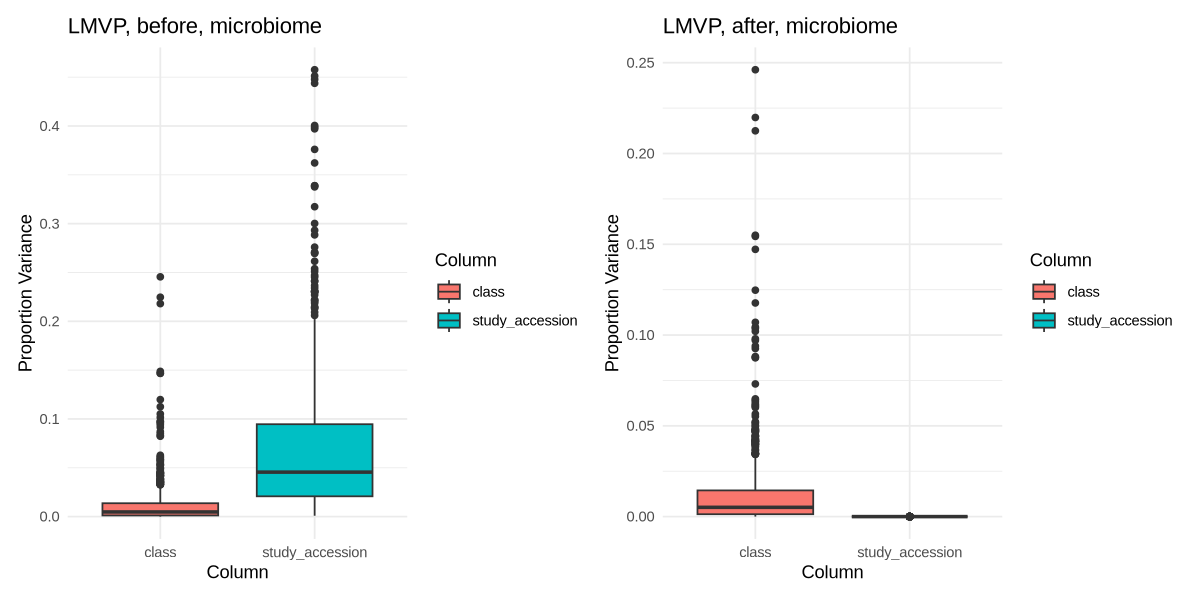

In [26]:

lmpv_plots_corrected <- lmpv_plot(central_corrected, metadata, 
    title = paste("LMVP, after, microbiome"))
lmpv_plot_uncorrected <- lmpv_plot(central_uncorrected, metadata, 
    title = paste("LMVP, before, microbiome"))


layout <- (lmpv_plot_uncorrected + lmpv_plots_corrected) 

options(repr.plot.width=10, repr.plot.height=5)
layout